In [1]:
import numpy as np
import scipy.io as sio
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

data_file = 'data/preprocessed.mat'

EPS = 1e-8

In [2]:
data = sio.loadmat(data_file)

In [3]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'images', 'bags', 'labels', 'n_instance', 'instance_dim'])

In [4]:
X = data['bags']
Y = data['labels']
Y[Y == -1] = 0 #convert to 1,0 labelling

In [5]:
n_instance = data['n_instance']
instance_dim = np.prod(data['instance_dim'])
n_classes = Y.shape[1]

# Train, validate, test split

In [6]:
test_prop = 1/3
validate_prop = 1/6

random_state = 42

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,                            
    test_size=test_prop,                             
    random_state=random_state
)

X_train, X_validate, Y_train, Y_validate = train_test_split(
    X_train, Y_train,                   
    test_size=validate_prop/(1-test_prop), 
    random_state=random_state
)

In [7]:
print(Y_train.shape)
print(Y_validate.shape)
print(Y_test.shape)

(999, 5)
(334, 5)
(667, 5)


In [8]:
X_train.shape

(999, 20, 1200)

# Simple linear model

Linear model:
$$h_{ijk} = W_k^T \vec{x_{ij}}$$ 

Each instance can be at most one class:
$$p_{ijk} = \frac{e^{h_{ijk}}}{\sum_{k' = 1}^K e^{h_{ijk'}}}$$

Probability that at least one instance in bag $i$ is of class k:
$$p_{i \bullet k} = P(y_{i \bullet k} = 1) = P(\exists j \in \{1,\ldots,J\}; y_{ijk} = 1) = 1 - \prod_{j = 1}^J (1-p_{ijk})$$

Score cross entropy on each (assuming independence):
$$\mathcal{L}_{W_k} = -\sum_{i=1}^I y_{i \bullet k}log(p_{i \bullet k}) + (1-y_{i \bullet k})log(1 - p_{i \bullet k})$$

$$\mathcal{L}_\mathbf{W} = \sum_{k=1}^K \mathcal{L}_{W_k}$$

Taking derivatives: 
$$\frac{\partial\mathcal{L}_\mathbf{W}}{\partial W_{k'}} = \sum_{k=1}^K \frac{\partial \mathcal{L}_{W_k}}{\partial W_{k'}}$$



$$\frac{\partial \mathcal{L}_{W_k}}{\partial W_{k'}} = -\sum_{i=1}^I \frac{\partial \mathcal{L}_{W_k}}{\partial p_{i \bullet k}} \frac{\partial p_{i \bullet k}}{\partial W_{k'}} $$


$$\frac{\partial \mathcal{L}_{W_k}}{\partial p_{i \bullet k}} =  \frac{p_{i \bullet k} - y_{i \bullet k}}{p_{i \bullet k}(1-p_{i \bullet k})} $$

$$\frac{\partial p_{i \bullet k}}{\partial W_{k'}} = \sum_{j = 1}^J \frac{\partial p_{ijk}}{\partial W_{k'}} \prod_{j' = 1, \ j' \neq j}^J (1-p_{ij'k})$$

$$\frac{\partial p_{ijk}}{\partial W_{k'}} = \frac{\partial p_{ijk}}{\partial h_{ijk'}}\frac{\partial h_{ijk'}}{\partial W_{k'}}$$

$$\frac{\partial p_{ijk}}{\partial h_{ijk'}} = \begin{cases}
    p_{ijk}(1-p_{ijk'}),& \text{if } k' = k\\
    -p_{ijk}p_{ijk'},              & \text{if } k' \neq k
\end{cases} = p_{ijk}(\delta_{kk'} - p_{ijk'}) \text{ where } \delta_{kk'} = \begin{cases}
    1,& \text{if } k' = k\\
    0 ,              & \text{if} k' \neq k
\end{cases}$$

$$\frac{\partial h_{ijk'}}{\partial W_{k'}} = \vec{x_{ij}}$$

In [124]:
def LW(x, y, w):
    h_ijk = np.einsum('lk,ijl->ijk', w, x)
    p_ijk = np.divide(np.exp(h_ijk), np.sum(np.exp(h_ijk), 2)[:,:,np.newaxis] + EPS)
    p_i_k = 1 - np.prod(1-p_ijk, 1)
    L = -np.sum(y*np.log(p_i_k + EPS) + (1-y)*np.log(1-p_i_k + EPS))


    dh_ijkp_dW_kp = x

    d_kkp = np.eye(w.shape[1])

    dp_ijk_dh_ijkp = np.einsum(
        'ijk,ijpk->ijkp',
        p_ijk, 
        d_kkp[np.newaxis, np.newaxis,:] - p_ijk[:,:,:,np.newaxis]
    )

    dp_ijk_dW_kp = (dp_ijk_dh_ijkp[:,:,:,:,np.newaxis]*dh_ijkp_dW_kp[:,:,np.newaxis, np.newaxis,:])

    dp_i_k_dW_kp = np.zeros(np.array(dp_ijk_dW_kp.shape)[[0,2,3,4]])
    for j in range(p_ijk.shape[1]):
        cp = np.copy(p_ijk)
        cp[:,j,:] = 1
        dp_i_k_dW_kp = dp_i_k_dW_kp + (dp_ijk_dW_kp[:,j,:,:] * np.prod(cp, 1)[:, :, np.newaxis, np.newaxis])

    dL_W_k_dp_i_k = (p_i_k - y) / (p_i_k*(1 - p_i_k) + EPS)

    dL_W_k_dW_kp = np.sum(dL_W_k_dp_i_k[:,:, np.newaxis, np.newaxis] * dp_i_k_dW_kp, 0)

    dL = np.transpose(np.sum(dL_W_k_dW_kp, 0))

    return(L, dL)

In [125]:
def train(x, y, w0, epochs = 100, mb_size = 50, lr = .01):
    w = np.copy(w0)
    n_batches = int(len(y)/float(mb_size))
    losses = []
    for epoch in range(epochs):
        idxs = np.arange(len(y))
        np.random.shuffle(idxs)
        epochloss = 0
        for batch in range(n_batches):
            mb_idxs = idxs[batch*mb_size:(1+batch)*mb_size]
            x_mb = x[mb_idxs]
            y_mb = y[mb_idxs]
            loss, grad = LW(x_mb, y_mb, w)
            epochloss += loss/n_batches
            
            w = w - lr*grad
        losses.append(epochloss)
    plt.plot(losses)
    return(w)

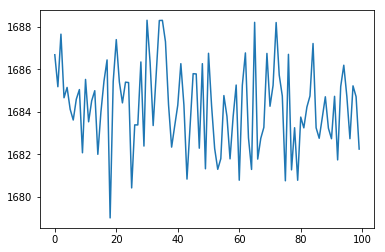

In [126]:
w0 = np.random.normal(0, .000002, (instance_dim, n_classes))
w = train(X_train, Y_train, w0, epochs = 100, mb_size = 100, lr = .01)